In [1]:
using Revise, UnboundedBNN, Plots, ProgressMeter, Optimisers, Zygote, StatsFuns, LinearAlgebra, Random

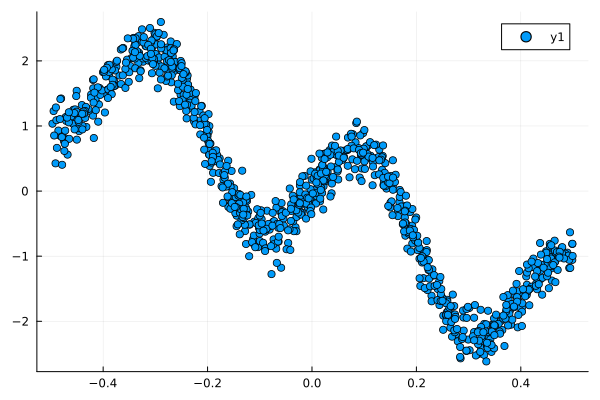

In [2]:
T = Float32
N = 1000
data_x = rand(T, N) .- 0.5f0
data_y = sin.(5*pi*data_x) .- 4 * data_x .+ 0.2f0 * randn(T, N)
plot(data_x, data_y, seriestype = :scatter)

In [3]:
function loss(y, x, m; batch_prop = 1)
    @assert 0 < batch_prop <= 1

    # calculate KL divergence between posterior and prior of distribution over number of layers
    kl_poisson = KL_loss(m.posterior, m.prior)

    # calculate KL divergence between posterior and prior of distribution over weights of input layer
    kl_expansion = KL_loss(m.input_layer)
    
    # weighted KL over hidden and output layers
    mq = UnboundedBNN.support(m.posterior)
    kl_hidden_layers = KL_loss.(m.hidden_layers)
    kl_output_layers = KL_loss.(m.output_layers)
    ql = UnboundedBNN.pdf.(Ref(m.posterior), mq)
    kl_layers = map(mq) do index
        return ql[index+1] * (sum(kl_hidden_layers[1:index+1]) + kl_output_layers[index+1])
    end

    kl_total = kl_poisson #+ kl_expansion + sum(kl_layers)
    
    # calculate expected log likelihood
    loglikelihoods = map(zip(x,y)) do (xi, yi)
        out = m(xi, 0)
        o_mean = vcat(first.(out)...)
        o_var = vcat(last.(out)...)
        logln = normlogpdf.(o_mean, sqrt.(o_var), yi)
        return dot(logln, ql)
    end
    expected_logl = sum(loglikelihoods)

    return -expected_logl + batch_prop * kl_total
end

loss (generic function with 1 method)

In [4]:
function predict(x, m)
    mq = UnboundedBNN.support(m.posterior)
    ql = UnboundedBNN.pdf.(Ref(m.posterior), mq)
    out = map(x) do xi
        o = m(xi, 0)
        o_mean = vcat(first.(o)...)
        o_var = vcat(last.(o)...)
        # THIS IS MOST LIKELY WRONG
        return dot(o_mean, ql), dot(o_var, ql)
    end
    return first.(out), last.(out)
end

predict (generic function with 1 method)

In [11]:
dimin = 1
dimmid = 10
dimout = 1

max_layers = 20

expansion_layer = LinearSpike(dimin => dimmid)
intermediate_layer = ntuple(_ -> Skip(Chain(LinearSpike(dimmid => dimmid), ReLU(), LinearSpike(dimmid => dimmid))), max_layers)
output_layer = ntuple(_ -> LinearSpike(dimmid => dimout), max_layers)
prior = Poisson(1)
posterior = SafeTruncatedPoisson([invsoftplus(1f0)])
model = Unbounded(expansion_layer, intermediate_layer, output_layer, prior, posterior)

opt = Optimisers.setup(Adam(), model)
Optimisers.adjust!(opt, 0.005f0)
Optimisers.adjust!(opt.posterior, 0.0005f0)

In [32]:
epochs = 100
batch_size = 32
l_mem = zeros(epochs)
gs = nothing
@showprogress for e in 1:epochs
    for n in Iterators.partition(randperm(N), batch_size)
        _, gs = Zygote.withgradient(m -> loss(data_y[n], data_x[n], m; batch_prop = length(n)/N), model)
        opt, model = Optimisers.update!(opt, model, gs[1])
    end
    l_mem[e] = loss(data_y, data_x, model)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:32


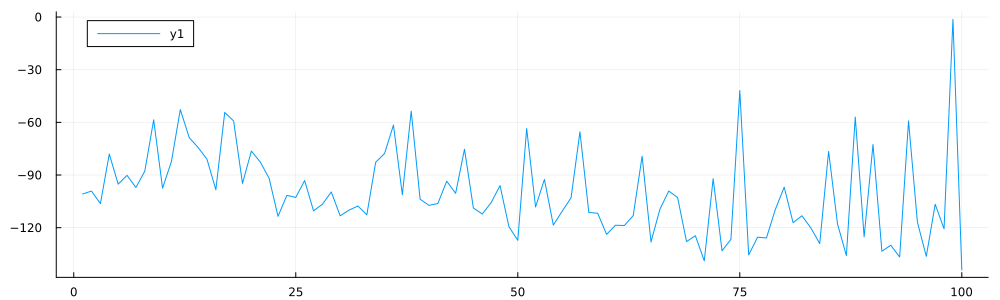

In [33]:
plot(l_mem, size=(1000,300))

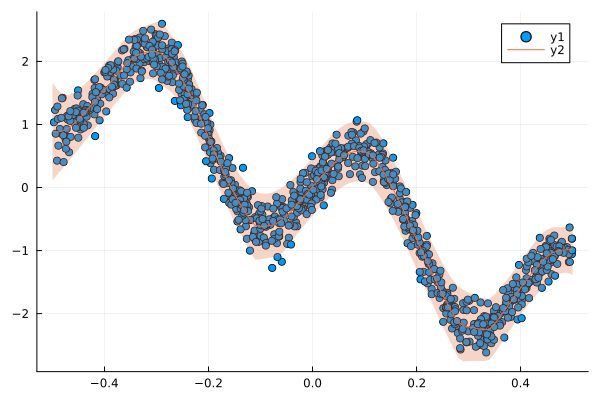

In [34]:
x_test = -0.5:0.01:0.5
y_test_mean, y_test_var = predict(x_test, model)
plot(data_x, data_y, seriestype = :scatter)
plot!(x_test, y_test_mean, ribbon = 2*sqrt.(y_test_var), fillalpha = 0.3)

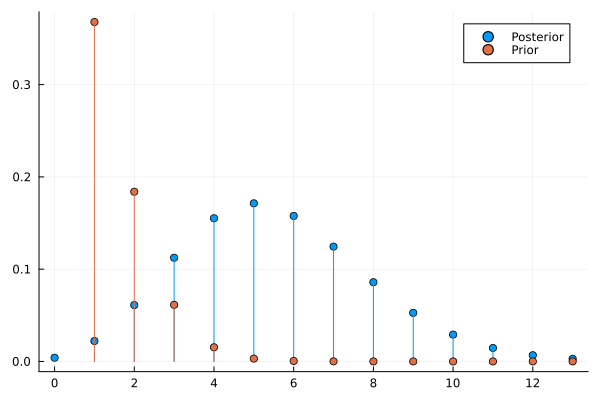

In [35]:
plot(UnboundedBNN.support(model.posterior), UnboundedBNN.pdf.(Ref(model.posterior), UnboundedBNN.support(model.posterior)), line=:stem, marker=:circle, label="Posterior")
plot!(UnboundedBNN.support(model.posterior), UnboundedBNN.pdf.(Ref(model.prior), UnboundedBNN.support(model.posterior)), line=:stem, marker=:circle, label="Prior")

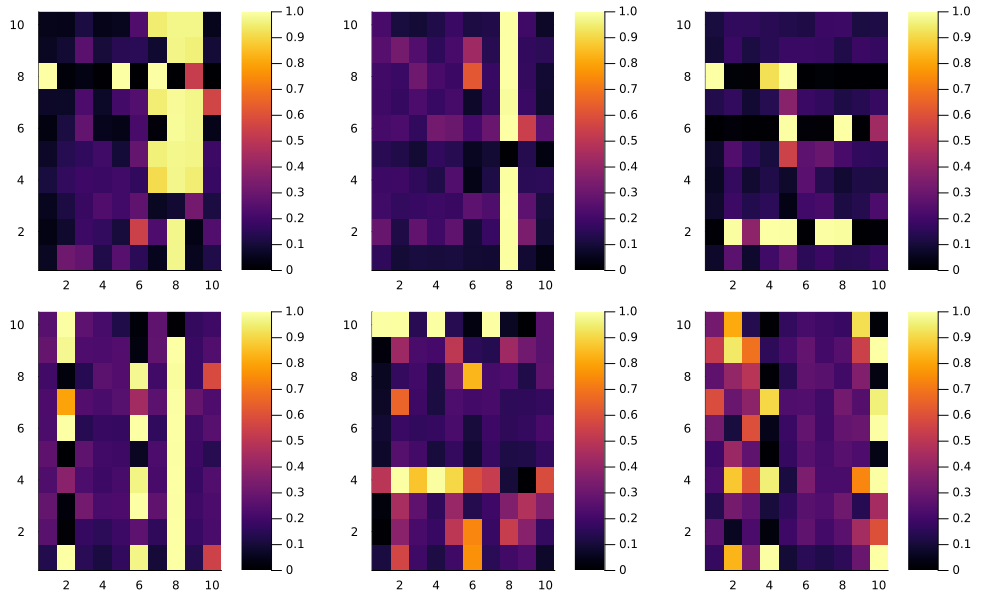

In [36]:
p1 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[1].layer.layers[1].zW), clim = (0,1))
p2 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[1].layer.layers[3].zW), clim = (0,1))
p3 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[2].layer.layers[1].zW), clim = (0,1))
p4 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[2].layer.layers[3].zW), clim = (0,1))
p5 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[3].layer.layers[1].zW), clim = (0,1))
p6 = heatmap(UnboundedBNN.sigmoid.(model.hidden_layers[3].layer.layers[3].zW), clim = (0,1))
plot(p1, p2, p3, p4, p5, p6, layout = (2,3), size = (1000, 600))